# Neural Network Implementation
We finally approach the neural network implementation of this paper. Now must make Train, Test Split. And find some metrics to measure on.

In [49]:
# Packages
import numpy as np
import pandas as pd
import torch
import scipy.stats as stats
import scipy.optimize as optim
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# All Required DataSets
IVSurface = np.load('testSurface.pkl', allow_pickle = True)
SP500 = np.load('SP500.pkl', allow_pickle = True)
VIX = np.load('VIX.pkl', allow_pickle = True)
hugeData = np.load('rawIVChange2.pkl', allow_pickle = True)

In [50]:
mergedData = pd.merge(pd.merge(IVSurface, SP500, how = 'left', on = 'Date'), VIX, how = 'left', on = 'Date')
mergedData = mergedData.filter(['strike', 'daysExp', 'fittedIV', 'Returns', 'VIX'])
mergedData['IVChange'] = mergedData.fittedIV.diff(periods = 441)
mergedData = mergedData.shift(periods = -441).dropna()
mergedData.daysExp = mergedData.daysExp
mergedData.strike = mergedData.strike
mergedData.to_pickle('finalDataSet.pkl')

## Raw IV Change

In [51]:
hugeData = hugeData.merge(SP500.loc['2014-01-01':'2017-12-31'], how = 'left', on = 'Date')
hugeData['moneyness'] = hugeData.strike / hugeData.SP500
hugeData = hugeData[(hugeData.DaysChange <= 5) | (hugeData.moneyness >= 0.6)]
hugeData = hugeData.merge(VIX.loc['2014-01-01':'2017-12-31'], how = 'left', on = 'Date')
hugeData.IVChange = hugeData.IVChange / hugeData.DaysChange

In [52]:
hugeData = hugeData.filter(['daysExp', 'delta', 'IVChange', 'Returns', 'VIX', 'moneyness'])
hugeData.daysExp = hugeData.daysExp / 250
hugeData = hugeData[abs(hugeData.IVChange) < 0.25]
hugeData = hugeData[hugeData.VIX.isna() == False]

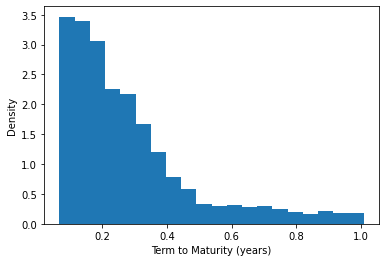

In [53]:
plt.hist(hugeData.daysExp, bins = 20, density = True)
plt.xlabel('Term to Maturity (years)')
plt.ylabel('Density')
plt.savefig('Ttm.eps')

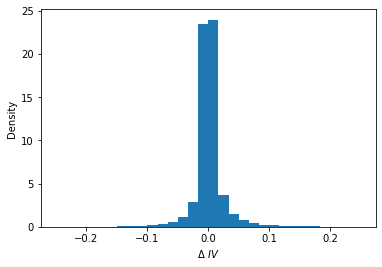

In [54]:
plt.hist(hugeData.IVChange, bins = 30, density = True)
plt.xlabel('$\Delta ~ IV$')
plt.ylabel('Density')
plt.savefig('IV.eps')

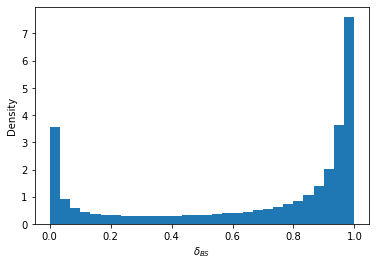

In [55]:
plt.hist(hugeData.delta, bins = 30, density = True)
plt.xlabel('$\delta_{BS}$')
plt.ylabel('Density')
plt.savefig('delta.eps')

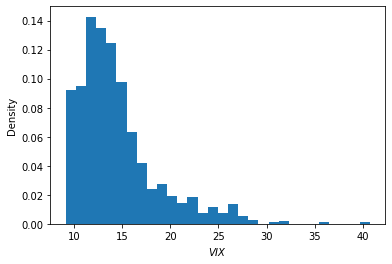

In [56]:
plt.hist(hugeData.VIX, bins = 30, density = True)
plt.xlabel('$VIX$')
plt.ylabel('Density')
plt.savefig('VIX.eps')

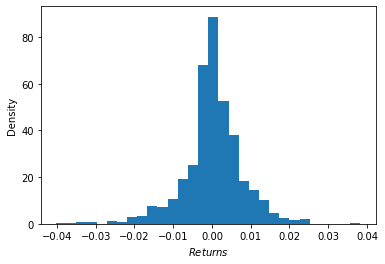

In [57]:
plt.hist(hugeData.Returns, bins = 30, density = True)
plt.xlabel('$Returns$')
plt.ylabel('Density')
plt.savefig('returns.eps')

## Benchmark Model Raw IV

In [58]:
trainingDataRaw, testDataRaw = train_test_split(hugeData, test_size = 0.3)

def hull_white_function(X, a, b, c):
    moneyness = X[0,:]
    timeToMaturity = X[1,:]
    returns = X[2,:]
    
    quadraticTerm = a + b * moneyness + c * moneyness ** 2
    return returns * quadraticTerm / np.sqrt(timeToMaturity)

## Comparison Benchmark Data
yData = np.array(trainingDataRaw.IVChange).T
xData = np.array(trainingDataRaw.filter(['delta', 'daysExp', 'Returns'])).T

fittedVal = optim.curve_fit(hull_white_function, xData, yData)
aHull, bHull, cHull = fittedVal[0]

In [59]:
fittedVal[0]

array([ 0.03011125, -0.03016958,  0.13727561])

## General Neural Network PyTorch DataLoader

In [60]:
class Raw_Factor_Model_Dataloader():
    def __init__(self, X, y, scale_data = True):
        if scale_data:
            X = StandardScaler().fit_transform(X)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

## Three Factor Neural Network with Raw IV

In [61]:
class Raw_Three_Factor_Model(nn.Module):
    '''Multilayer Feed Forward Network for regression'''
    def __init__(self, hiddenNodes, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, hiddenNodes),
            nn.ReLU(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.ReLU(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.ReLU(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [62]:
[X, y] = [trainingDataRaw.filter(['delta', 'daysExp', 'Returns']).values,
          trainingDataRaw.filter(['IVChange']).values]

torchTrainingSet = Raw_Factor_Model_Dataloader(X, y)
trainLoader = torch.utils.data.DataLoader(torchTrainingSet, batch_size = 4096, shuffle = True, num_workers = 0)

[XTest, yTest] = [testDataRaw.filter(['delta', 'daysExp', 'Returns']).values,
          testDataRaw.filter(['IVChange']).values]

torchTestSet = Raw_Factor_Model_Dataloader(XTest, yTest)
testLoader = torch.utils.data.DataLoader(torchTestSet, batch_size = testDataRaw.shape[0], shuffle = True, num_workers = 0)


In [63]:
raw_three_factor_model = Raw_Three_Factor_Model(80, 0.25)
loss_func = nn.MSELoss()

epochs = 50
opt = torch.optim.Adam(raw_three_factor_model.parameters(), lr = 1e-4)
progress3F = []

for epoch in range(0, epochs):
    tic = time.time()
    current_loss = 0
    
    for i, data in enumerate(trainLoader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        opt.zero_grad()
        outputs = raw_three_factor_model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        opt.step()
        current_loss += loss.item()
        
    progress3F.append(current_loss)        
    if (epoch + 1) % 10 == 0:
        print('Loss after Epoch %5d: %.5f' % (epoch+1, current_loss))
        toc = time.time()
        print('Training Time Epoch %5d: %.5f' % (epoch + 1, toc - tic))
        
print('Training finished')

Loss after Epoch    10: 0.23379
Training Time Epoch    10: 13.47431
Loss after Epoch    20: 0.22883
Training Time Epoch    20: 13.94808
Loss after Epoch    30: 0.21975
Training Time Epoch    30: 13.78595
Loss after Epoch    40: 0.21051
Training Time Epoch    40: 13.65843
Loss after Epoch    50: 0.20603
Training Time Epoch    50: 13.87041
Training finished


<IPython.core.display.Javascript object>


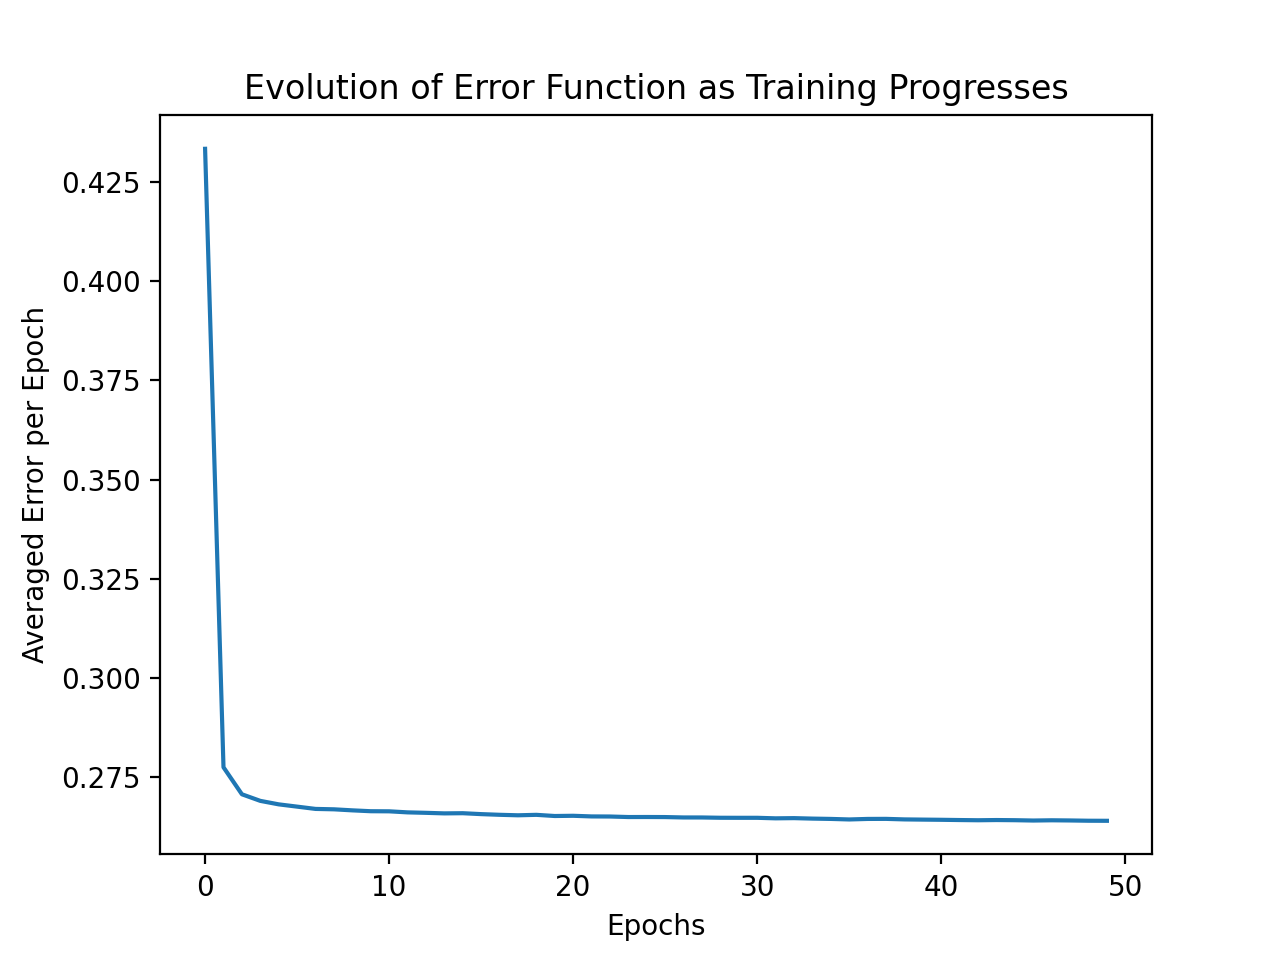

In [441]:
plt.plot(progress3F)
plt.xlabel("Epochs")
plt.ylabel("Averaged Error per Epoch")
plt.title("Evolution of Error Function as Training Progresses")
plt.savefig("3FactorTraining.eps")

In [442]:
# Three Factor Predictions
for i, data in enumerate(testLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
raw_three_factor_model.eval()
raw_3 = raw_three_factor_model(inputs)

performance3F = sum((raw_3.detach().numpy() - targets.detach().numpy())**2)

## Four Factor Neural Network with Raw IV

In [30]:
class Raw_Four_Factor_Model(nn.Module):
    '''Multilayer Feed Forward Network for regression'''
    def __init__(self, hiddenNodes, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, hiddenNodes),
            nn.ReLU(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.ReLU(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.ReLU(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, 1),
        )
        
    def forward(self, x):
        return self.layers(x)

In [343]:
[X, y] = [trainingDataRaw.filter(['delta', 'daysExp', 'Returns', 'VIX']).values,
          trainingDataRaw.filter(['IVChange']).values]

torchTrainingSet = Raw_Factor_Model_Dataloader(X, y)
trainLoader = torch.utils.data.DataLoader(torchTrainingSet, batch_size = 4096, shuffle = True, num_workers = 0)

[XTest, yTest] = [testDataRaw.filter(['delta', 'daysExp', 'Returns', 'VIX']).values,
          testDataRaw.filter(['IVChange']).values]

torchTestSet = Raw_Factor_Model_Dataloader(XTest, yTest)
testLoader = torch.utils.data.DataLoader(torchTestSet, batch_size = testDataRaw.shape[0], shuffle = True, num_workers = 0)



In [344]:
raw_four_factor_model = Raw_Four_Factor_Model(80, 0.25)
loss_func = nn.MSELoss()

epochs = 50
opt = torch.optim.Adam(raw_four_factor_model.parameters(), lr = 1e-4)
progress4F = []

for epoch in range(0, epochs):
    tic = time.time()
    current_loss = 0
    
    for i, data in enumerate(trainLoader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        opt.zero_grad()
        outputs = raw_four_factor_model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        opt.step()
        current_loss += loss.item()
        
    progress4F.append(current_loss)        
    if (epoch + 1) % 10 == 0:
        print('Loss after Epoch %5d: %.5f' % (epoch+1, current_loss))
        toc = time.time()
        print('Training Time Epoch %5d: %.5f' % (epoch + 1, toc - tic))
        
print('Training finished')


Loss after Epoch    10: 0.26479
Training Time Epoch    10: 15.91515
Loss after Epoch    20: 0.25624
Training Time Epoch    20: 15.85107
Loss after Epoch    30: 0.24193
Training Time Epoch    30: 15.79889
Loss after Epoch    40: 0.23088
Training Time Epoch    40: 16.04131
Loss after Epoch    50: 0.22567
Training Time Epoch    50: 15.93710
Training finished


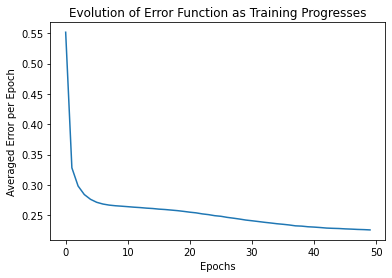

In [345]:
plt.plot(progress4F)
plt.xlabel("Epochs")
plt.ylabel("Averaged Error per Epoch")
plt.title("Evolution of Error Function as Training Progresses")
plt.savefig("4FactorTraining.png")

In [346]:
# Four Factor Predictions
for i, data in enumerate(testLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
raw_four_factor_model.eval()
raw_4 = raw_four_factor_model(inputs)
performance_4F = sum((raw_4.detach().numpy() - targets.detach().numpy())**2)


In [347]:
# Hull White Predictions
xEval = np.array(testDataRaw.filter(['delta', 'daysExp', 'Returns'])).T
hullWhitePred = hull_white_function(xEval, aHull, bHull, cHull)
hullWhitePerformance = sum((hullWhitePred - targets.detach().numpy()[:,0])**2)

## Comparisons of Results

In [443]:
performance = [performance3F, performance_4F, hullWhitePerformance]
performance

[array([266.42453], dtype=float32),
 array([224.26797], dtype=float32),
 276.9032359948275]

In [349]:
gain = [1 - performance[0]/performance[2], 1 - performance[1]/performance[0], 1 - performance[1]/performance[2]]
print('Gain of 3F over Hull-White: %.3f' % gain[0])
print('Gain of 4F over 3F: %.3f' % gain[1])
print('Gain of 4F over Hull-White: %.3f' % gain[2])

Gain of 3F over Hull-White: 0.164
Gain of 4F over 3F: 0.031
Gain of 4F over Hull-White: 0.190


## Summary of Findings of 4 Factor Model

In [ ]:
TtmIndex = np.linspace(30, 150, 11)/250
deltaIndex = np.linspace(0.4,0.6, 101)
vixIndex = np.array([13, 16, 20])
retIndex = np.array([-0.0125, -0.005, -0.0075, 0.0075, 0.005, 0.0125])
TtmCol, deltaCol, retCol, vixCol = pd.core.reshape.util.cartesian_product([TtmIndex, deltaIndex, retIndex, vixIndex])#, retIndex])
summaryStatistics = pd.DataFrame(dict(delta = deltaCol, timeToMaturity = TtmCol, returns = retCol, VIX = vixCol))

[XStat, yStat] = [summaryStatistics.values,
          np.zeros_like(summaryStatistics.timeToMaturity)]

summarySet = Raw_Factor_Model_Dataloader(XStat, yStat)
summaryLoader = torch.utils.data.DataLoader(summarySet, batch_size = summaryStatistics.shape[0], shuffle = False, num_workers = 0)

for i, data in enumerate(summaryLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
raw_four_factor_model.eval()
summaryIVChange = raw_four_factor_model(inputs)

summaryStatistics['IVChange'] = summaryIVChange.detach().numpy() * 10000 # In Basis Points
summaryStatistics['timeToMaturity'] = summaryStatistics['timeToMaturity'] * 250 # In Days
summaryStatistics['returns'] = summaryStatistics['returns'] * 100 # In percent



# We now try to extend this model to a fitted IV Surface

## Training Data and Testing Data

In [25]:
trainingDataFit, testDataFit = train_test_split(mergedData, test_size = 0.3)

## Preparing 4 Factor Dataset

In [69]:
[X, y] = [trainingDataFit.filter(['strike', 'daysExp', 'Returns', 'VIX']).values,
          trainingDataFit.filter(['IVChange']).values]

torchTrainingSet = Raw_Factor_Model_Dataloader(X, y)
trainLoader = torch.utils.data.DataLoader(torchTrainingSet, batch_size = 5000, shuffle = True, num_workers = 0)

[XTest, yTest] = [testDataFit.filter(['strike', 'daysExp', 'Returns', 'VIX']).values,
          testDataFit.filter(['IVChange']).values]

torchTestSet = Raw_Factor_Model_Dataloader(XTest, yTest)
testLoader = torch.utils.data.DataLoader(torchTestSet, batch_size = testDataFit.shape[0], shuffle = False, num_workers = 0)

## Training Four Factor Neural Network

In [35]:
four_factor_model = Raw_Four_Factor_Model(80, 0.25)
loss_func = nn.MSELoss()

epochs = 50
opt = torch.optim.Adam(four_factor_model.parameters(), lr = 1e-4)
progress = []

for epoch in range(0, epochs):
    tic = time.time()
    current_loss = 0
    
    for i, data in enumerate(trainLoader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        opt.zero_grad()
        outputs = four_factor_model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        opt.step()
        current_loss += loss.item()

    progress.append(current_loss)        
    if (epoch + 1) % 10 == 0:
        print('Loss after Epoch %5d: %.5f' % (epoch+1, current_loss))
        toc = time.time()
        print('Training Time Epoch %5d: %.5f' % (epoch + 1, toc - tic))
        
print('Training finished')

Loss after Epoch    10: 0.11367
Training Time Epoch    10: 2.97175
Loss after Epoch    20: 0.10639
Training Time Epoch    20: 2.93200
Loss after Epoch    30: 0.10425
Training Time Epoch    30: 2.98612
Loss after Epoch    40: 0.10325
Training Time Epoch    40: 2.96401
Loss after Epoch    50: 0.10293
Training Time Epoch    50: 2.86393
Training finished


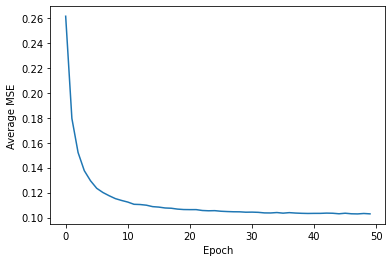

In [102]:
plt.plot(progress)
plt.xlabel('Epoch')
plt.ylabel('Average MSE')
plt.savefig("SVILoss.eps")

In [76]:
for i, data in enumerate(testLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))
four_factor_model.eval()
nn4F = four_factor_model(inputs)

We now reparameterise the Hull-White function, using strike as a percentage of spot as a proxy for moneyness rather than $\delta_{BS}$

In [70]:
def hull_white_function(X, a, b, c):
    moneyness = X[0,:]
    timeToMaturity = X[1,:]
    returns = X[2,:]
    
    quadraticTerm = a + b * moneyness + c * moneyness ** 2
    return returns * quadraticTerm / np.sqrt(timeToMaturity)

## Comparison Benchmark Data
yData = np.array(trainingDataFit.IVChange).T
xData = np.array(trainingDataFit.filter(['strike', 'daysExp', 'Returns'])).T

fittedVal = optim.curve_fit(hull_white_function, xData, yData)
aHull, bHull, cHull = fittedVal[0]

In [71]:
fittedVal

(array([ 16.31092705, -52.22606697,  32.82022644]),
 array([[ 2.69196192, -6.11646343,  3.34105438],
        [-6.11646343, 14.04399438, -7.7378471 ],
        [ 3.34105438, -7.7378471 ,  4.29766637]]))

In [72]:
xEval = np.array(testDataFit.filter(['strike', 'daysExp', 'Returns'])).T
hullWhitePred = hull_white_function(xEval, aHull, bHull, cHull)

# Results

In [79]:
evaluations = np.stack([nn4F.detach().numpy()[:,0], hullWhitePred, targets.detach().numpy()[:,0]], axis = 1)
evaluations = pd.DataFrame(evaluations, columns = [ '4F_Model', 'Hull_White', 'Targets'])


In [80]:
performance = [sum((evaluations['4F_Model'] - evaluations.Targets)**2), sum((evaluations.Hull_White - evaluations.Targets)**2)]
performance

[213.5411683703885, 217.3111302428382]

In [108]:
gain = [1 - performance[0]/performance[1]]
gain


[0.017348222653100542]

In [148]:
TtmIndex = np.linspace(30, 150, 50)/250
strikeIndex = np.linspace(0.6,1.2, 50)
vixIndex = np.array([13, 16, 20])
retIndex = np.array([-0.0125, -0.005, -0.0075, 0.0075, 0.005, 0.0125])
TtmCol, strikeCol, retCol, vixCol = pd.core.reshape.util.cartesian_product([TtmIndex, strikeIndex, retIndex, vixIndex])#, retIndex])
summaryStatistics = pd.DataFrame(dict(strike = strikeCol, timeToMaturity = TtmCol, returns = retCol, VIX = vixCol))

[XStat, yStat] = [summaryStatistics.values,
          np.zeros_like(summaryStatistics.timeToMaturity)]

summarySet = Raw_Factor_Model_Dataloader(XStat, yStat)
summaryLoader = torch.utils.data.DataLoader(summarySet, batch_size = summaryStatistics.shape[0], shuffle = False, num_workers = 0)

for i, data in enumerate(summaryLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
four_factor_model.eval()
summaryIVChange = four_factor_model(inputs)

summaryStatistics['IVChange'] = summaryIVChange.detach().numpy() * 10000 # In Basis Points
summaryStatistics['timeToMaturity'] = summaryStatistics['timeToMaturity'] * 250 # In Days
summaryStatistics['returns'] = summaryStatistics['returns'] * 100 # In percent
#summaryStatistics[(summaryStatistics.returns == -.5)&(summaryStatistics.strike == 1.2)&(summaryStatistics.VIX == 20)]


<IPython.core.display.Javascript object>


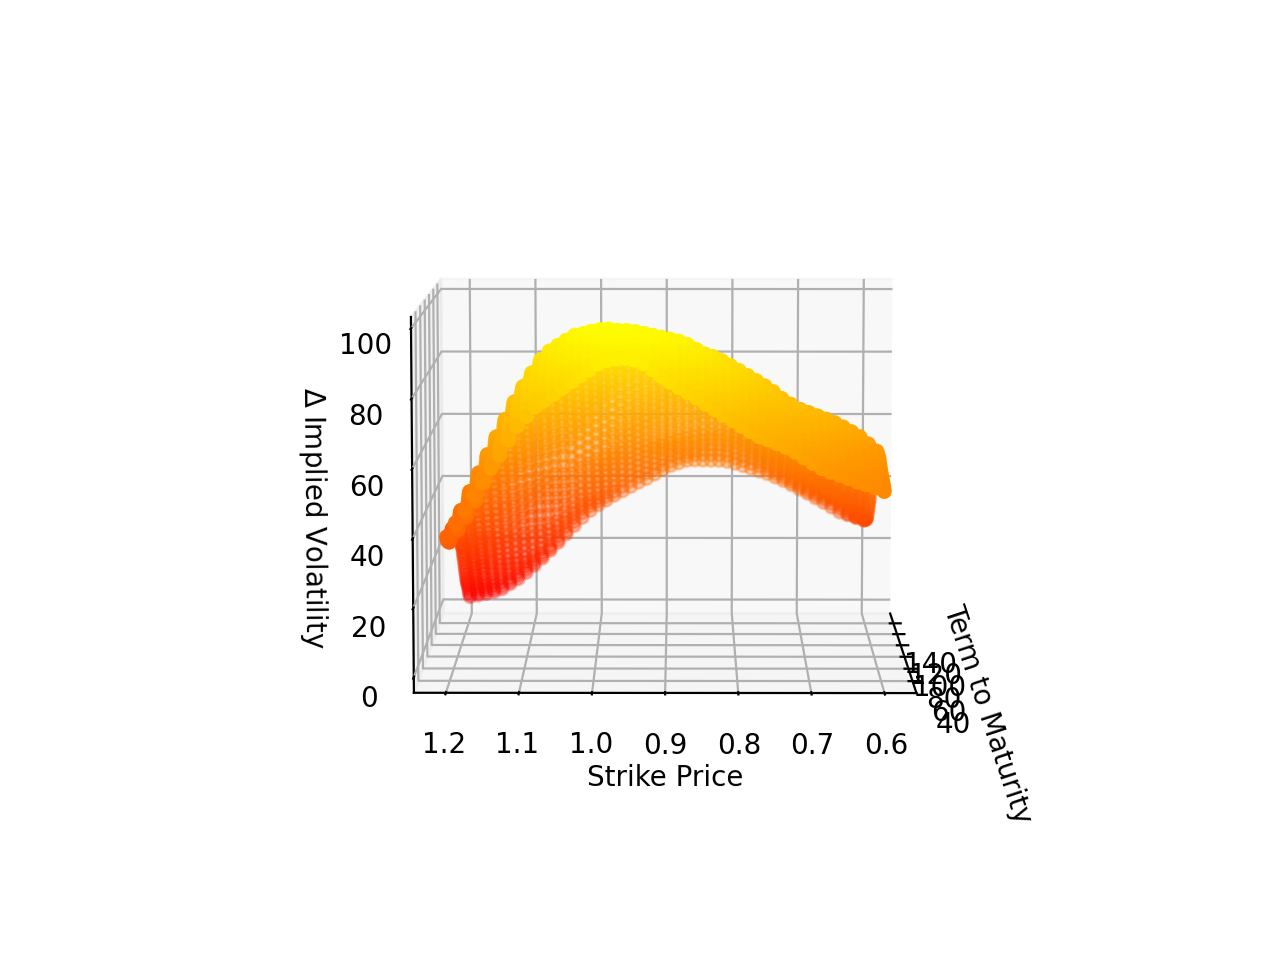

Text(0.5, 0, '$\\Delta$ Implied Volatility')

In [150]:
%matplotlib notebook
fig = plt.figure('Change')
ax = fig.add_subplot(projection='3d')

plotSet = summaryStatistics[(summaryStatistics.returns == -.5)&(summaryStatistics.VIX == 20)]

ax.scatter(plotSet.timeToMaturity, plotSet.strike, plotSet.IVChange, cmap = 'autumn', c = plotSet.IVChange)
ax.set_xlabel('Term to Maturity')
ax.set_ylabel('Strike Price')
ax.set_zlabel('$\Delta$ Implied Volatility')